In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mne
!pip install pymatreader
!pip install python-picard
!pip install hfda

import mne
import pymatreader
import scipy
import numpy as np
import pandas as pd
import scipy.io as sio
import os
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

import sklearn.multioutput as MOR
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.signal import welch
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from mne.decoding import Vectorizer
from mne.decoding import Scaler, PSDEstimator, FilterEstimator
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import hfda

import matplotlib.pyplot as plt
from scipy.signal import welch
import scipy.stats as stats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# %matplotlib widget
# %matplotlib qt
%matplotlib inline

In [ ]:
# Import files from mydata
X_data=np.zeros([9,95,14,512])
y_data=np.zeros([9,95,3])

for participant in range(9):
  path='/content/drive/My Drive/Dissertation/MYDATA_NEW/s0'+str(participant+1)+'/'
  X=pd.read_csv(path+'data_s0'+str(participant+1)+'.csv')
  X=X.iloc[:,1:]
  X=X.to_numpy()
  for epoch in range(95):
    X_data[participant][epoch]=np.transpose(X[512*epoch:512*(epoch+1)])

  y=pd.read_csv(path+'labels_s0'+str(participant+1)+'.csv')
  y=y.iloc[:,1:]
  y=y.to_numpy()
  y_data[participant]=y

path_00='/content/drive/My Drive/Dissertation/MYDATA_NEW/s00/'

X_00_data=np.zeros([94,14,512])
X_00=pd.read_csv(path_00+'data_s00.csv')
X_00=X_00.iloc[:,1:]
X_00=X_00.to_numpy()
for epoch in range(94):
  X_00_data[epoch]=np.transpose(X_00[512*epoch:512*(epoch+1)])

y_00=pd.read_csv(path_00+'labels_s00.csv')
y_00=y_00.iloc[:,1:]
y_00=y_00.to_numpy()

X_new=np.zeros([9,95,14,512])
X_data.shape


(9, 95, 14, 512)

In [ ]:
# SIGNAL PROCESSING
channels=['F3','FC5','AF3','F7','T7','P7','O1','O2','P8','T8','F8','AF4','FC6','F4']
sigs=['ecg', 'bio', 'stim', 'eog', 'misc', 'seeg', 'dbs', 'ecog', 'mag','eeg','ref_meg', 'grad', 'emg', 'hbr','hbo']
info=mne.create_info(ch_names=channels,sfreq=128,ch_types='eeg')

for participant in range(X_data.shape[0]):
  for epoch in range(X_data.shape[1]):
    raw=mne.io.RawArray(X_data[participant][epoch],info)
    eeg_channels = mne.pick_types(raw.info, eeg=True,emg=True,ecg=True)
    cov=mne.compute_raw_covariance(raw, picks=eeg_channels)

    raw.del_proj()

    # BANDPASS FILTER
    filt_raw = raw.copy().filter(l_freq=4, h_freq=50,picks=eeg_channels)

    # ICA
    ica = ICA(n_components=14,noise_cov=cov,method='fastica',max_iter='auto',random_state=97)
    ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)
    ica.exclude = [2]
    reconst_raw = filt_raw.copy()
    ica.apply(reconst_raw)

    # X_NEW
    X_new[participant][epoch]=reconst_raw.get_data()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# DATA NORMALIZATION
X_new_=np.zeros([9,95,14,512])
for participant in range(X_new.shape[0]):
  mu=np.mean(X_new[participant],axis=0)
  std=np.std(X_new[participant],axis=0,ddof=1)
  for epoch in range(X_new.shape[1]):
    X_new_[participant][epoch]=(X_new[participant][epoch]-mu)/std

In [ ]:
# PSEUDO CLASSIFIER
def pseudo(X,y,estimator):
  "Classifier that is used to generate pseudo-labels for observations in data that are unlabelled"
  # INDICES
  unlabelled_indices=np.where(y==0)
  labelled_indices=np.where(y!=0)

  # LABELLED/UNLABELLED DATA WITH TARGETS
  X_labelled=X[labelled_indices]
  y_labelled=y[labelled_indices]

  X_unlabelled=X[unlabelled_indices]

  # PREDICTIONS FOR PSEUDO-LABELS
  regr_labelled=estimator.fit(X_labelled,y_labelled)
  pred_labelled=regr_labelled.predict(X_unlabelled)

  y[unlabelled_indices]=pred_labelled

  return y


In [ ]:
# CORRECTION ON SOME DATA
y_data[5,:,0][:5]=np.array([3,0,4,0,8])

In [ ]:
# PSEUDO-LABELLING
vec=Vectorizer()
y_new=np.zeros([9,95,3])
estimator=svm.SVC(kernel='rbf',C=0.1)
X_new__=np.zeros([9,95,14,129])
X_new_transformed=np.zeros([9,95,1806])
for participant in range(X_new_.shape[0]):
  X_new__[participant]=welch(X_new_[participant], fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
  X_new_transformed[participant]=vec.fit_transform(X_new__[participant])
  y_new[participant,:,0]=pseudo(X_new_transformed[participant],y_data[participant,:,0],estimator)
  y_new[participant,:,1]=pseudo(X_new_transformed[participant],y_data[participant,:,1],estimator)
  y_new[participant,:,2]=pseudo(X_new_transformed[participant],y_data[participant,:,2],estimator)

In [ ]:
# RESULTS OF PSEUDO
for i in range(9):
  print(y_new[i])
  print('')

[[3. 7. 4.]
 [3. 6. 4.]
 [3. 7. 4.]
 [4. 7. 4.]
 [8. 8. 8.]
 [7. 6. 7.]
 [2. 4. 4.]
 [3. 4. 4.]
 [7. 9. 7.]
 [3. 8. 4.]
 [3. 7. 4.]
 [3. 6. 4.]
 [4. 8. 4.]
 [9. 9. 8.]
 [8. 8. 7.]
 [3. 4. 3.]
 [3. 3. 2.]
 [7. 8. 7.]
 [3. 6. 6.]
 [3. 7. 4.]
 [3. 6. 4.]
 [4. 7. 4.]
 [9. 9. 8.]
 [8. 8. 7.]
 [3. 7. 4.]
 [3. 5. 4.]
 [6. 8. 5.]
 [3. 7. 7.]
 [3. 7. 6.]
 [3. 7. 4.]
 [4. 8. 4.]
 [9. 9. 9.]
 [8. 8. 8.]
 [2. 4. 3.]
 [3. 8. 3.]
 [3. 8. 4.]
 [7. 8. 7.]
 [4. 7. 3.]
 [3. 8. 4.]
 [3. 6. 4.]
 [3. 7. 4.]
 [9. 9. 9.]
 [3. 6. 4.]
 [3. 4. 3.]
 [3. 7. 4.]
 [3. 7. 6.]
 [4. 6. 4.]
 [3. 3. 4.]
 [3. 5. 4.]
 [3. 8. 4.]
 [8. 8. 8.]
 [3. 7. 4.]
 [3. 4. 4.]
 [6. 7. 8.]
 [7. 7. 8.]
 [4. 8. 4.]
 [3. 5. 5.]
 [3. 7. 4.]
 [3. 8. 4.]
 [9. 9. 9.]
 [3. 8. 4.]
 [3. 3. 4.]
 [6. 8. 7.]
 [7. 7. 8.]
 [4. 8. 4.]
 [3. 3. 2.]
 [3. 8. 4.]
 [3. 8. 4.]
 [9. 9. 9.]
 [3. 7. 4.]
 [3. 5. 4.]
 [3. 7. 6.]
 [3. 4. 4.]
 [9. 9. 9.]
 [3. 3. 2.]
 [3. 6. 4.]
 [3. 8. 4.]
 [7. 9. 7.]
 [3. 6. 4.]
 [4. 7. 4.]
 [7. 8. 6.]
 [3. 7. 4.]
 [9. 9. 9.]
 [3.

In [ ]:
# SPLITTING OF DATA
# POWER SPECTRAL DENSITY
vec=Vectorizer()
_X_new_=np.zeros([9,95,1806])
psd_svr=np.zeros([9,95,14,129])

rmse_svm=[]
mae_svm=[]
for participant in range(X_new.shape[0]):
  psd_svr[participant]=welch(X_new_[participant], fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
  _X_new_[participant]=vec.fit_transform(psd_svr[participant])
  X_train, X_test, y_train, y_test = train_test_split(_X_new_[participant], y_new[participant], test_size=0.2, random_state=42)

  # REGRESSION 
  # With SVR
  svr=svm.SVR(kernel='rbf',C=1.0,epsilon=0.2)
  clf=MOR.MultiOutputRegressor(svr)
  y_pred=cross_val_predict(clf,_X_new_[participant],y_new[participant],cv=5)

  # METRICS FOR SVR
  MSE=mean_squared_error(y_new[participant],y_pred)
  MAE=mean_absolute_error(y_new[participant],y_pred)
  R2=r2_score(y_new[participant],y_pred)
  print('RMSE for participant {} = {}'.format(participant,np.sqrt(MSE)))
  print('MAE for participant {} = {}'.format(participant,MAE))
  print('R2 for participant {} = {}'.format(participant,R2))
  print('')
  rmse_svm.append(MSE)
  mae_svm.append(MAE)

RMSE for participant 0 = 2.0475476853039973
MAE for participant 0 = 1.493909513047164
R2 for participant 0 = -0.11054242326060759

RMSE for participant 1 = 2.015656563384656
MAE for participant 1 = 1.3781311185096712
R2 for participant 1 = -0.07609869491730399

RMSE for participant 2 = 1.7638692738749346
MAE for participant 2 = 1.3467723189890313
R2 for participant 2 = -0.12852812311973327

RMSE for participant 3 = 1.3051253743249482
MAE for participant 3 = 0.9731570712506441
R2 for participant 3 = -0.020979787874382

RMSE for participant 4 = 1.7850131812516838
MAE for participant 4 = 1.0847840957495982
R2 for participant 4 = -0.0743254767576228

RMSE for participant 5 = 2.3213821692452363
MAE for participant 5 = 1.4698776510224096
R2 for participant 5 = -0.12291944377613635

RMSE for participant 6 = 1.642484380578131
MAE for participant 6 = 1.0750131102646938
R2 for participant 6 = -0.0668888663592712

RMSE for participant 7 = 1.8975779816248204
MAE for participant 7 = 1.4354297703148

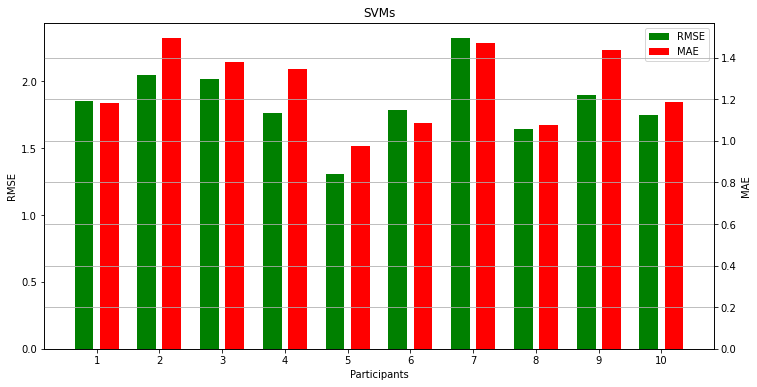

In [ ]:
# Plot results in bar charts
parts=np.arange(1,11)
lst=[1,2,3,4,5,6,7,8,9,10]
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot()
ax=plt.gca()
lns1=ax.bar(parts-0.2,np.sqrt(rmse_svm),0.3,color='green',label='RMSE')
ax2=ax.twinx()
lns2=ax2.bar(parts+0.2,mae_svm,0.3,color='red',label='MAE')
plt.xticks(parts, lst)

ax.set_xlabel('Participants')
ax.set_ylabel('RMSE')
ax2.set_ylabel('MAE')

ax.legend([lns1,lns2],['RMSE','MAE'],loc=0)
plt.title('SVMs')
plt.grid(True)
plt.show()

In [ ]:
# SPLITTING OF DATA
X_new_knn=np.zeros([9,95,1806])
psd_knn=np.zeros([9,95,14,129])
rmse_knn=[]
mae_knn=[]
for participant in range(X_new.shape[0]):
  psd_knn[participant]=welch(X_new_[participant], fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
  X_new_knn[participant]=vec.fit_transform(psd_knn[participant])
  X_train, X_test, y_train, y_test = train_test_split(X_new_knn[participant], y_new[participant], test_size=0.2, random_state=42)

  # REGRESSION 
  # With k-NNS
  knn=KNeighborsRegressor(n_neighbors=71)
  regr_knn=MOR.MultiOutputRegressor(knn)
  y_pred_knn=cross_val_predict(regr_knn,X_new_knn[participant],y_new[participant],cv=5)

  # METRICS FOR k-NN
  MSE_knn=mean_squared_error(y_new[participant],y_pred_knn)
  MAE_knn=mean_absolute_error(y_new[participant],y_pred_knn)
  R2_knn=r2_score(y_new[participant],y_pred_knn)
  print('RMSE for participant {} = {}'.format(participant,np.sqrt(MSE_knn)))
  print('MAE for participant {} = {}'.format(participant,MAE_knn))
  print('R2 for participant {} = {}'.format(participant,R2_knn))
  print('')
  rmse_knn.append(MSE_knn)
  mae_knn.append(MAE_knn)

RMSE for participant 0 = 1.9475355591729961
MAE for participant 0 = 1.644329132690882
R2 for participant 0 = -0.01027731830178813

RMSE for participant 1 = 1.937096196747662
MAE for participant 1 = 1.542525327403015
R2 for participant 1 = -0.005980506519856488

RMSE for participant 2 = 1.6844108453731255
MAE for participant 2 = 1.4222881146528294
R2 for participant 2 = -0.03490516670475411

RMSE for participant 3 = 1.3183973432373621
MAE for participant 3 = 1.0350877192982457
R2 for participant 3 = -0.02027661549760666

RMSE for participant 4 = 1.7191301456447945
MAE for participant 4 = 1.1956016802569804
R2 for participant 4 = -0.033249858597687997

RMSE for participant 5 = 2.197685470942759
MAE for participant 5 = 1.720286632073141
R2 for participant 5 = -0.00507504387808914

RMSE for participant 6 = 1.5896720036907024
MAE for participant 6 = 1.1772176921176178
R2 for participant 6 = -0.02139659787666585

RMSE for participant 7 = 1.8198056330846264
MAE for participant 7 = 1.483518655

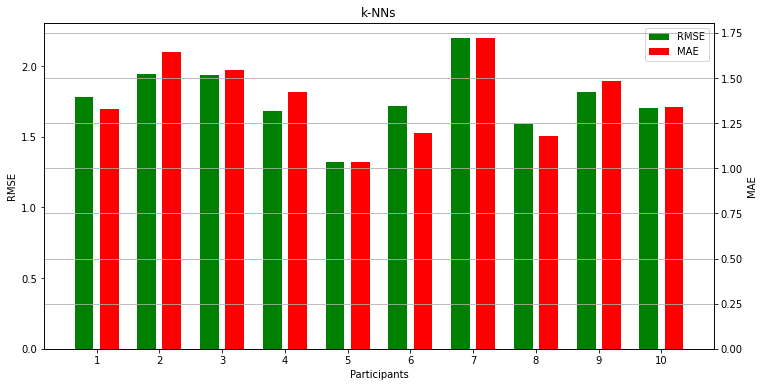

In [ ]:
# Plot results in bar charts
parts=np.arange(1,11)
lst=[1,2,3,4,5,6,7,8,9,10]
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot()
ax=plt.gca()
lns1=ax.bar(parts-0.2,np.sqrt(rmse_knn),0.3,color='green',label='RMSE')
ax2=ax.twinx()
lns2=ax2.bar(parts+0.2,mae_knn,0.3,color='red',label='MAE')
plt.xticks(parts, lst)

ax.set_xlabel('Participants')
ax.set_ylabel('RMSE')
ax2.set_ylabel('MAE')

ax.legend([lns1,lns2],['RMSE','MAE'],loc=0)
plt.title('k-NNs')
plt.grid(True)
plt.show()

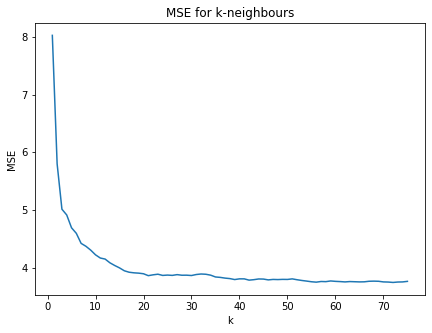


Number of k with lowest MSE equal to 71 and with MSE equal to 3.745488818496859


In [ ]:
# HYPER-PARAMETER TUNING FOR K-NNS
dec=X_new_[1]
psd_knn=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
psd_knn=vec.fit_transform(psd_knn)

mse=[]
for k in range(1,76):
  knn=KNeighborsRegressor(n_neighbors=k)
  regr_knn=MOR.MultiOutputRegressor(knn)
  y_pred_knn=cross_val_predict(regr_knn,psd_knn,y_new[1],cv=5)
  MSE_knn=mean_squared_error(y_new[1],y_pred_knn)
  mse.append(MSE_knn)

k=np.where(mse==np.min(mse))


import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.plot(range(1,76),mse)
plt.title('MSE for k-neighbours')
plt.xlabel('k')
plt.ylabel('MSE')
plt.show()
print('')
print('Number of k with lowest MSE equal to {} and with MSE equal to {}'.format(k[0][0],np.min(mse)))

In [ ]:
# SPLITTING OF DATA
X_new_rf=np.zeros([9,95,1806])
psd_rf=np.zeros([9,95,14,129])

rmse_rf=[]
mae_rf=[]
for participant in range(X_new.shape[0]):
  psd_rf[participant]=welch(X_new_[participant], fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
  X_new_rf[participant]=vec.fit_transform(psd_rf[participant])
  X_train, X_test, y_train, y_test = train_test_split(X_new_rf[participant], y_new[participant], test_size=0.2, random_state=42)

  # REGRESSION
  # With RFs
  rf=RandomForestRegressor(n_estimators=59, criterion='squared_error', max_depth=5)
                          
  regr_rf=MOR.MultiOutputRegressor(rf)
  y_pred_rf=cross_val_predict(regr_rf,X_new_rf[participant],y_new[participant],cv=5)

  # METRICS FOR RF
  MSE_rf=mean_squared_error(y_new[participant],y_pred_rf)
  MAE_rf=mean_absolute_error(y_new[participant],y_pred_rf)
  R2_rf=r2_score(y_new[participant],y_pred_rf)
  print('RMSE for participant {} = {}'.format(participant,np.sqrt(MSE_rf)))
  print('MAE for participant {} = {}'.format(participant,MAE_rf))
  print('R2 for participant {} = {}'.format(participant,R2_rf))
  print('')
  rmse_rf.append(MSE_rf)
  mae_rf.append(MAE_rf)

RMSE for participant 0 = 1.9498038584117086
MAE for participant 0 = 1.6394518777509672
R2 for participant 0 = -0.014089468543160288

RMSE for participant 1 = 1.9752497953182109
MAE for participant 1 = 1.560137172752081
R2 for participant 1 = -0.042914859738328946

RMSE for participant 2 = 1.734135480750463
MAE for participant 2 = 1.4590499740595302
R2 for participant 2 = -0.1007436322824969

RMSE for participant 3 = 1.2191968401729254
MAE for participant 3 = 0.9563904666551496
R2 for participant 3 = 0.03251143914223845

RMSE for participant 4 = 1.772866572511992
MAE for participant 4 = 1.2740521250875962
R2 for participant 4 = -0.08597561662986952

RMSE for participant 5 = 2.3748960117881195
MAE for participant 5 = 1.8874148707828071
R2 for participant 5 = -0.1545700609211446

RMSE for participant 6 = 1.646531682736156
MAE for participant 6 = 1.2091093949071328
R2 for participant 6 = -0.0651368896324634

RMSE for participant 7 = 1.869165796563183
MAE for participant 7 = 1.5407009705727

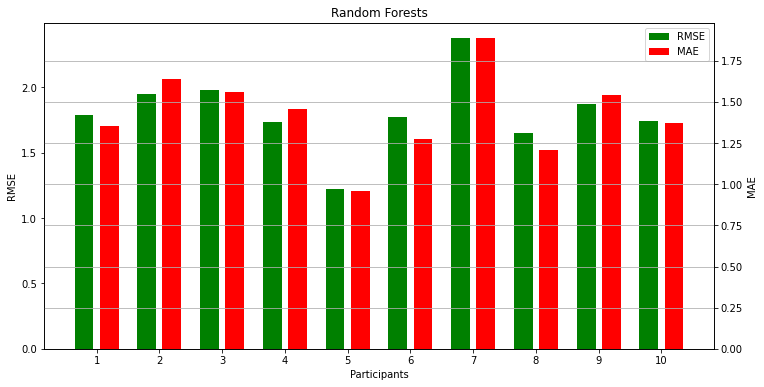

In [ ]:
# Plot results in bar charts
parts=np.arange(1,11)
lst=[1,2,3,4,5,6,7,8,9,10]
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot()
ax=plt.gca()
lns1=ax.bar(parts-0.2,np.sqrt(rmse_rf),0.3,color='green',label='RMSE')
ax2=ax.twinx()
lns2=ax2.bar(parts+0.2,mae_rf,0.3,color='red',label='MAE')
plt.xticks(parts, lst)

ax.set_xlabel('Participants')
ax.set_ylabel('RMSE')
ax2.set_ylabel('MAE')

ax.legend([lns1,lns2],['RMSE','MAE'],loc=0)
plt.title('Random Forests')
plt.grid(True)
plt.show()

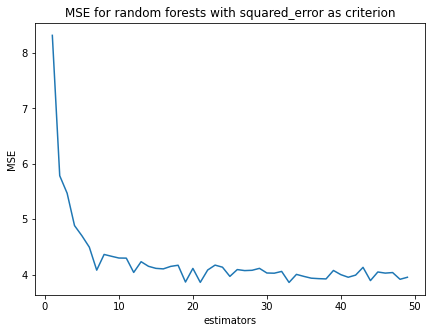


Number of estimators with lowest MSE equal to 32 and with MSE equal to 3.8605190662606925


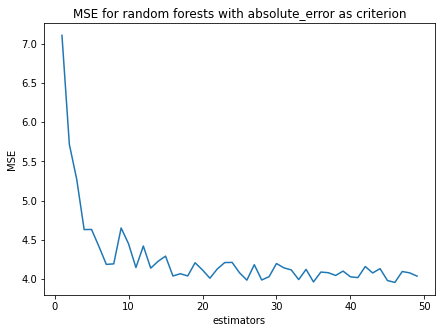


Number of estimators with lowest MSE equal to 45 and with MSE equal to 3.955468775909527


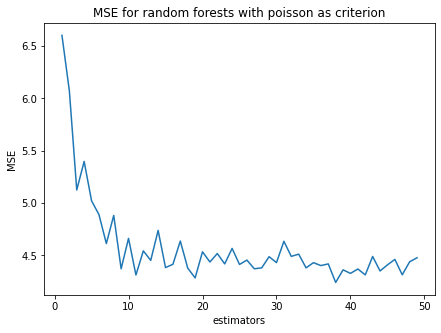


Number of estimators with lowest MSE equal to 37 and with MSE equal to 4.240683773144773


In [ ]:
# HYPER-PARAMETER TUNING FOR RANDOM FORESTS
dec=X_new_[1]
psd_rf=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
psd_rf=vec.fit_transform(psd_rf)


criteria=['squared_error','absolute_error', 'poisson']

for criterion in criteria:
  mse=[]
  for estimator in range(1,50):
    rf=RandomForestRegressor(n_estimators=estimator, criterion=criterion, max_depth=None)
    regr_rf=MOR.MultiOutputRegressor(rf)
    y_pred_rf=cross_val_predict(regr_rf,psd_rf,y_new[1],cv=5)
    MSE_rf=mean_squared_error(y_new[1],y_pred_rf)
    mse.append(MSE_rf)

  _k=np.where(mse==np.min(mse))

  plt.figure(figsize=(7,5))
  plt.plot(range(1,50),mse)
  plt.title('MSE for random forests with {} as criterion'.format(criterion))
  plt.xlabel('estimators')
  plt.ylabel('MSE')
  plt.show()
  print('')
  print('Number of estimators with lowest MSE equal to {} and with MSE equal to {}'.format(_k[0][0],np.min(mse)))

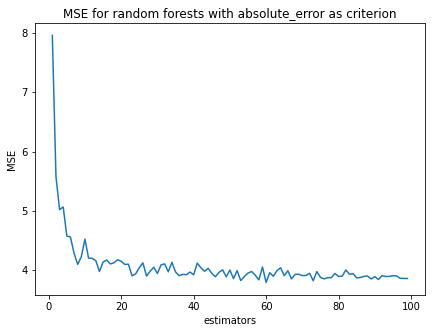


Number of estimators with lowest MSE equal to 59 and with MSE equal to 3.7944434697855747


In [ ]:
# TUNING FOR NUMBER OF ESTIMATORS
dec=X_new_[1]
psd_rf=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
psd_rf=vec.fit_transform(psd_rf)
X_train, X_test, y_train, y_test = train_test_split(psd_rf, y_new[1], test_size=0.2, random_state=42)

mse=[]
for estimator in range(1,100):
  rf=RandomForestRegressor(n_estimators=estimator, criterion='squared_error', max_depth=None)
  regr_rf=MOR.MultiOutputRegressor(rf)
  y_pred_rf=cross_val_predict(regr_rf,psd_rf,y_new[1],cv=5)
  MSE_rf=mean_squared_error(y_new[1],y_pred_rf)
  mse.append(MSE_rf)

_k=np.where(mse==np.min(mse))

import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.plot(range(1,100),mse)
plt.title('MSE for random forests with {} as criterion'.format('squared_error'))
plt.xlabel('estimators')
plt.ylabel('MSE')
plt.show()
print('')
print('Number of estimators with lowest MSE equal to {} and with MSE equal to {}'.format(_k[0][0],np.min(mse)))

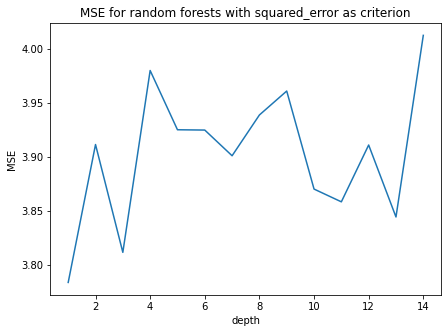


Maximum depth with lowest MSE equal to 0 and with MSE equal to 3.7833437243572186


In [ ]:
# TUNING FOR MAX-DEPTH
dec=X_new_[1]
psd_rf=welch(dec, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
psd_rf=vec.fit_transform(psd_rf)
X_train, X_test, y_train, y_test = train_test_split(psd_rf, y_new[1], test_size=0.2, random_state=42)

mse=[]
for depth in range(1,15):
  rf=RandomForestRegressor(n_estimators=59, criterion='squared_error', max_depth=depth)
  regr_rf=MOR.MultiOutputRegressor(rf)
  y_pred_rf=cross_val_predict(regr_rf,psd_rf,y_new[1],cv=5)
  MSE_rf=mean_squared_error(y_new[1],y_pred_rf)
  mse.append(MSE_rf)

_k=np.where(mse==np.min(mse))

plt.figure(figsize=(7,5))
plt.plot(range(1,15),mse)
plt.title('MSE for random forests with {} as criterion'.format('squared_error'))
plt.xlabel('depth')
plt.ylabel('MSE')
plt.show()
print('')
print('Maximum depth with lowest MSE equal to {} and with MSE equal to {}'.format(_k[0][0],np.min(mse)))

In [ ]:
# SIGNAL PROCESSING FOR THE FIRST PARTICIPANT
channels=['F3','FC5','AF3','F7','T7','P7','O1','O2','P8','T8','F8','AF4','FC6','F4']
sigs=['ecg', 'bio', 'stim', 'eog', 'misc', 'seeg', 'dbs', 'ecog', 'mag','eeg','ref_meg', 'grad', 'emg', 'hbr','hbo']
info=mne.create_info(ch_names=channels,sfreq=128,ch_types='eeg')
X_00_new=np.zeros([94,14,512])
for epoch in range(X_00_data.shape[0]):
  raw=mne.io.RawArray(X_00_data[epoch],info)
  eeg_channels = mne.pick_types(raw.info, eeg=True,emg=True,ecg=True)
  cov=mne.compute_raw_covariance(raw, picks=eeg_channels)

  raw.del_proj()

  # BANDPASS FILTER
  filt_raw = raw.copy().filter(l_freq=4, h_freq=50,picks=eeg_channels)

  # ICA
  ica = ICA(n_components=14,noise_cov=cov,method='fastica',max_iter='auto',random_state=97)
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)
  ica.exclude = [2]
  reconst_raw = filt_raw.copy()
  ica.apply(reconst_raw)
  X_00_new[epoch]=reconst_raw.get_data()

Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 14 dim * 7.7e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 14 dim * 7.6e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise cov

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 14 dim * 7.6e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise cov

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.5e+02 (2.2e-16 eps * 14 dim * 8e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covar

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.6e+02 (2.2e-16 eps * 14 dim * 8.3e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.3e+02 (2.2e-16 eps * 14 dim * 7.5e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise cov

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 14 dim * 7.9e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 14 dim * 7.7e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.5e+02 (2.2e-16 eps * 14 dim * 7.9e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Selecting by number: 14 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (plea

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 14 dim * 7.7e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise cov

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 14 dim * 7.6e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 14 dim * 7.6e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.3e+02 (2.2e-16 eps * 14 dim * 7.4e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 14 dim * 7.7e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.5e+02 (2.2e-16 eps * 14 dim * 7.9e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.5e+02 (2.2e-16 eps * 14 dim * 7.9e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff freque

<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(fi

Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.3e+02 (2.2e-16 eps * 14 dim * 7.4e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.3e+02 (2.2e-16 eps * 14 dim * 7.3e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 14 dim * 7.8e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.5e+02 (2.2e-16 eps * 14 dim * 8.1e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.3e+02 (2.2e-16 eps * 14 dim

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 14 dim * 7.8e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 14 dim * 7.7e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 14 dim * 7.6e+16  max singular value)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.3e+02 (2.2e-16 eps * 14 dim * 7.6e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Selecting by number: 14 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (plea

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Computing rank from covariance with rank=None
    Using tolerance 2.3e+02 (2.2e-16 eps * 14 dim * 7.5e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components


<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.3e+02 (2.2e-16 eps * 14 dim * 7.4e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 14 (0 small eigenvalues omitted)
Selecting by number: 14 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance


<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Computing rank from covariance with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 14 dim * 7.8e+16  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
    Setting s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=512
    Range : 0 ... 511 =      0.000 ...     3.992 secs
Ready.
Using up to 20 segments
Number of samples used : 520
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 213 samples (1.664 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a whil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
<ipython-input-13-10a4f663d299>:28: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  ica.fit(filt_raw,picks=eeg_channels,reject_by_annotation=True)


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


In [ ]:
# DATA NORMALIZATION FOR FIRST PARTICIPANT
X_new_00=np.zeros([94,14,512])
mu=np.mean(X_00_new,axis=0)
std=np.std(X_00_new,axis=0,ddof=1)
for epoch in range(X_00_new.shape[0]):
  X_new_00[epoch]=(X_00_new[epoch]-mu)/std

In [ ]:
# PSEUDO-LABELLING
vec=Vectorizer()
y_new_00=np.zeros([94,3])
estimator=svm.SVC(kernel='rbf',C=0.1)
X_00_transformed=np.zeros([94,1806])
w=welch(X_new_00, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
X_00_transformed=vec.fit_transform(w)
y_new_00[:,0]=pseudo(X_00_transformed,y_00[:,0],estimator)
y_new_00[:,1]=pseudo(X_00_transformed,y_00[:,1],estimator)
y_new_00[:,2]=pseudo(X_00_transformed,y_00[:,2],estimator)

In [ ]:
# MACHINE LEARNING for participant 0
# SPLITTING OF DATA
# POWER SPECTRAL DENSITY
vec=Vectorizer()
X_00_new_psd=np.zeros([94,1806])
psd_svr=np.zeros([94,14,129])

psd_svr=welch(X_new_00, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
X_00_new_psd=vec.fit_transform(psd_svr)
X_train, X_test, y_train, y_test = train_test_split(X_00_new_psd, y_new_00, test_size=0.2, random_state=42)

# REGRESSION 
# With SVR
svr=svm.SVR(kernel='rbf',C=1.0,epsilon=0.2)
clf=MOR.MultiOutputRegressor(svr)
y_pred=cross_val_predict(clf,X_00_new_psd,y_new_00,cv=5)

# METRICS FOR SVR
MSE=mean_squared_error(y_new_00,y_pred)
MAE=mean_absolute_error(y_new_00,y_pred)
R2=r2_score(y_new_00,y_pred)
print('RMSE for participant 0 = {}'.format(np.sqrt(MSE)))
print('MAE for participant 0 = {}'.format(MAE))
print('R2 for participant 0 = {}'.format(R2))
print('')
rmse_svm.insert(0,MSE)
mae_svm.insert(0,MAE)

RMSE for participant 0 = 1.8497471272201338
MAE for participant 0 = 1.1838935146724585
R2 for participant 0 = -0.06251259900602713



In [ ]:
# MACHINE LEARNING for participant 0
# SPLITTING OF DATA
# K-NEAREST NEIGHBORS
vec=Vectorizer()
X_00_new_psd=np.zeros([94,1806])
psd_knn=np.zeros([94,14,129])

psd_knn=welch(X_new_00, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
X_00_new_psd=vec.fit_transform(psd_knn)

# REGRESSION 
# With k-NNS
knn=KNeighborsRegressor(n_neighbors=71)
regr_knn=MOR.MultiOutputRegressor(knn)
y_pred_knn=cross_val_predict(regr_knn,X_00_new_psd,y_new_00,cv=5)

# METRICS FOR k-NN
MSE_knn=mean_squared_error(y_new_00,y_pred_knn)
MAE_knn=mean_absolute_error(y_new_00,y_pred_knn)
R2_knn=r2_score(y_new_00,y_pred_knn)
print('RMSE for participant 0 = {}'.format(np.sqrt(MSE_knn)))
print('MAE for participant 0 = {}'.format(MAE_knn))
print('R2 for participant 0 = {}'.format(R2_knn))
print('')
rmse_knn.insert(0,MSE_knn)
mae_knn.insert(0,MAE_knn)

RMSE for participant 0 = 1.7787606162850602
MAE for participant 0 = 1.326490860053941
R2 for participant 0 = -0.028258388687767717



In [ ]:
# MACHINE LEARNING for participant 0
# SPLITTING OF DATA
# POWER SPECTRAL DENSITY
vec=Vectorizer()
X_00_new_psd=np.zeros([94,1806])
psd_rf=np.zeros([94,14,129])

psd_rf=welch(X_new_00, fs=128, window='hann', detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')[1]
X_00_new_psd=vec.fit_transform(psd_rf)
X_train, X_test, y_train, y_test = train_test_split(X_00_new_psd, y_new_00, test_size=0.2, random_state=42)

# REGRESSION 
# With RF
rf=RandomForestRegressor(n_estimators=59, criterion='squared_error', max_depth=5)
regr_rf=MOR.MultiOutputRegressor(rf)
y_pred_rf=cross_val_predict(regr_rf,X_00_new_psd,y_new_00,cv=5)

# METRICS FOR RF
MSE_rf=mean_squared_error(y_new_00,y_pred_rf)
MAE_rf=mean_absolute_error(y_new_00,y_pred_rf)
R2_rf=r2_score(y_new_00,y_pred_rf)
print('RMSE for participant 0 = {}'.format(np.sqrt(MSE_rf)))
print('MAE for participant 0 = {}'.format(MAE_rf))
print('R2 for participant 0 = {}'.format(R2_rf))
print('')
rmse_rf.insert(0,MSE_rf)
mae_rf.insert(0,MAE_rf)

RMSE for participant 0 = 1.7899980468976247
MAE for participant 0 = 1.351274981917512
R2 for participant 0 = -0.06791135947512505

